<a href="https://colab.research.google.com/github/JuanDa14Sa/PageRank/blob/main/PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PageRank

En este notebook vamos a desarrollar el algoritmo de [PageRank](https://es.wikipedia.org/wiki/PageRank) desde cero y comparar el resultado con el obtenido usando la librería [networkx](https://networkx.org/documentation/stable/index.html). El fundamento teoríco se puede encontrar en [Google's PageRank and Beyond](https://gi.cebitec.uni-bielefeld.de/_media/teaching/2019winter/alggr/langville_meyer_2006.pdf).

## Librerías

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time

## Del grafo a la matriz

Mostremos los diferentes pasos realizados en el algoritmo. Para esto vamos a generar un dígrafo de 10 nodos

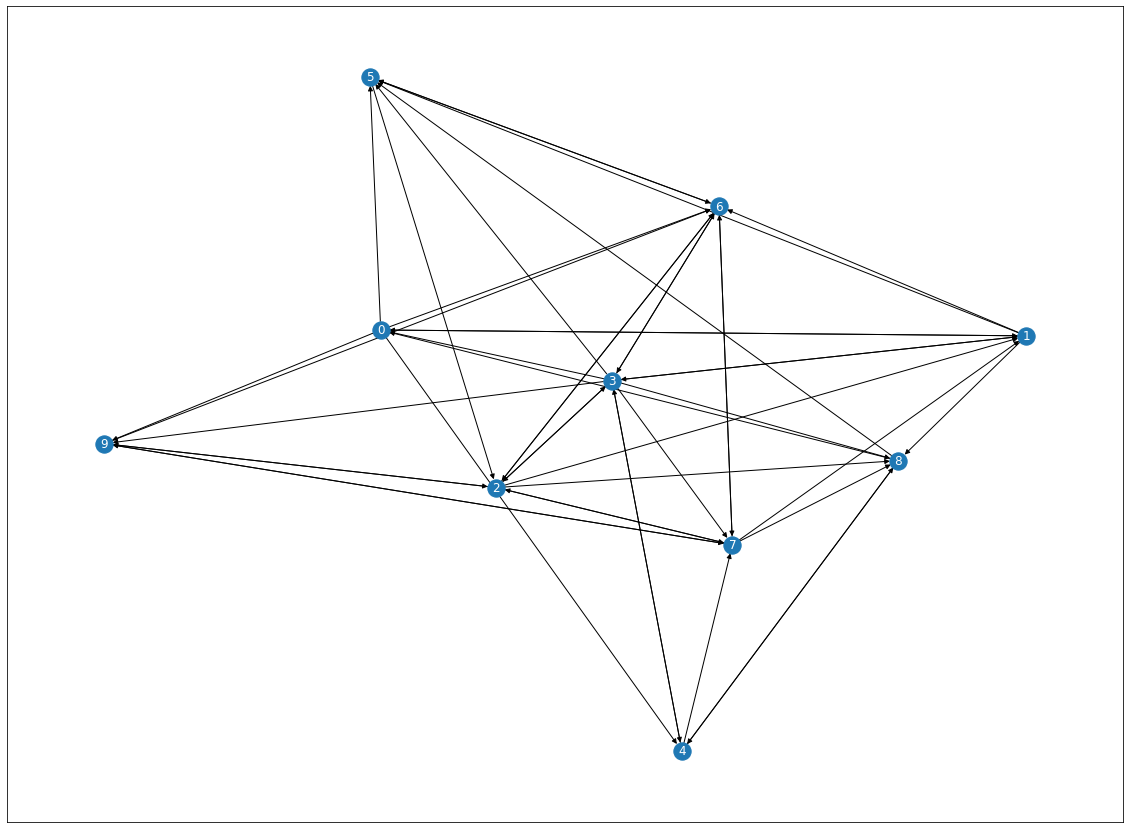

In [2]:
plt.figure(figsize=(20,15))
# created a directed graph
graph=nx.gnp_random_graph(10, 0.5, directed=True, seed=1)
#draw a graph
nx.draw_networkx(graph, with_labels=True, width=1, arrows=True, font_color='white')
#plot a graph
plt.show()

A continuación vemos la matriz de adyacencia $A$ del grafo, que corresponde a 
$$A_{i j}= \begin{cases}1 & \text { si }\left(v_i, v_j\right) \in E \\ 0 & \text { si }\left(v_i, v_j\right) \notin E .\end{cases}, $$

donde $E$ es el conjunto de aristas del grafo.

In [3]:
adj_matrix = nx.adjacency_matrix(graph).todense().astype(float)
adj_matrix

matrix([[0., 1., 0., 0., 1., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0., 1., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 0.]])

Ahora vamos a calcular la matriz subestocástica o matriz de hipervínculos $H$ tal que $$H_{i j}= \begin{cases}\frac{1}{|P_i|} & \text { si }\left(v_i, v_j\right) \in E \\ 0 & \text { si }\left(v_i, v_j\right) \notin E .\end{cases},$$
donde $|P_i|$ corresponde a la suma de los valores en la fila $i$-ésima.



In [4]:
def substochastic_mat(adj_matrix):
    k = np.sum(adj_matrix, axis=1)
    substochastic_matrix = np.divide(adj_matrix, k, out=np.zeros_like(adj_matrix), where=k!=0)
    return substochastic_matrix
substochastic_matrix = substochastic_mat(adj_matrix)
substochastic_matrix

matrix([[0.        , 0.2       , 0.        , 0.        , 0.2       ,
         0.2       , 0.2       , 0.        , 0.        , 0.2       ],
        [0.2       , 0.        , 0.        , 0.2       , 0.        ,
         0.2       , 0.2       , 0.        , 0.2       , 0.        ],
        [0.        , 0.16666667, 0.        , 0.16666667, 0.        ,
         0.        , 0.16666667, 0.16666667, 0.16666667, 0.16666667],
        [0.11111111, 0.11111111, 0.11111111, 0.        , 0.11111111,
         0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
        [0.        , 0.        , 0.        , 0.33333333, 0.        ,
         0.        , 0.        , 0.33333333, 0.33333333, 0.        ],
        [0.        , 0.        , 0.5       , 0.        , 0.        ,
         0.        , 0.5       , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.25      , 0.25      , 0.        ,
         0.25      , 0.        , 0.25      , 0.        , 0.        ],
        [0.        , 0.2   

Calculemos la matriz estocástica o matriz de Markov $S$ asociada.

$$S= H+a(1/ne^T),$$
donde $H$ es la matriz subestocástica, $a$ es un vector binario tal que $a_i=1$ si el nodo $i$ es colgante o aislado, es decir, un nodo sin aristas salientes, $n$ es el número de nodos y $e$ es el vector columna con todas sus componetes iguales a $1$.

In [5]:
def stochastic_mat(substochastic_matrix):
    stochastic_matrix = substochastic_matrix.copy()
    for i in range(len(substochastic_matrix)):
        if np.sum(substochastic_matrix, axis=1).tolist()[i]==0:
            stochastic_matrix[i,:] = 1/len(substochastic_matrix)
    stochastic_matrix /= stochastic_matrix.sum(axis=0)
    return stochastic_matrix
stochastic_matrix = stochastic_mat(substochastic_matrix)
stochastic_matrix

matrix([[0.        , 0.29508197, 0.        , 0.        , 0.31034483,
         0.18274112, 0.11688312, 0.        , 0.        , 0.29508197],
        [0.31034483, 0.        , 0.        , 0.21052632, 0.        ,
         0.18274112, 0.11688312, 0.        , 0.1978022 , 0.        ],
        [0.        , 0.24590164, 0.        , 0.1754386 , 0.        ,
         0.        , 0.0974026 , 0.13953488, 0.16483516, 0.24590164],
        [0.17241379, 0.16393443, 0.07968127, 0.        , 0.17241379,
         0.10152284, 0.06493506, 0.09302326, 0.10989011, 0.16393443],
        [0.        , 0.        , 0.        , 0.35087719, 0.        ,
         0.        , 0.        , 0.27906977, 0.32967033, 0.        ],
        [0.        , 0.        , 0.35856574, 0.        , 0.        ,
         0.        , 0.29220779, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.17928287, 0.26315789, 0.        ,
         0.2284264 , 0.        , 0.20930233, 0.        , 0.        ],
        [0.        , 0.2950

Finalmente calculamos la matriz $G$ llamada matriz de Google del grafo, está matriz es a la que finalmente se le aplica el algoritmo de PageRank, y dado que está es estocástica y primitiva entonces existe un único PageRank (vector estacionario de la cadena de Markov) que se puede hallar por medio del método de las potencias.


$$G=\alpha S +(1-\alpha)1/nee^T,$$\
donde $S$ es la matriz estocástica y $\alpha$ es un escalar entre $0$ y $1$, que corresponde a la probabilidad de seguir la estructura de las aristas (hipervínculos) o la de no saltar a un nodo (página) aleatoria.

In [6]:
def google_mat(stochastic_matrix, alpha=0.85): 
    e = np.ones(stochastic_matrix.shape)*(1-alpha)*(1/len(stochastic_matrix))
    google_matrix = stochastic_matrix.copy()
    google_matrix = google_matrix*alpha + e
    return google_matrix
google_matrix = google_mat(stochastic_matrix)
google_matrix

matrix([[0.015     , 0.26581967, 0.015     , 0.015     , 0.2787931 ,
         0.17032995, 0.11435065, 0.015     , 0.015     , 0.26581967],
        [0.2787931 , 0.015     , 0.015     , 0.19394737, 0.015     ,
         0.17032995, 0.11435065, 0.015     , 0.18313187, 0.015     ],
        [0.015     , 0.22401639, 0.015     , 0.16412281, 0.015     ,
         0.015     , 0.09779221, 0.13360465, 0.15510989, 0.22401639],
        [0.16155172, 0.15434426, 0.08272908, 0.015     , 0.16155172,
         0.10129442, 0.07019481, 0.09406977, 0.10840659, 0.15434426],
        [0.015     , 0.015     , 0.015     , 0.31324561, 0.015     ,
         0.015     , 0.015     , 0.2522093 , 0.29521978, 0.015     ],
        [0.015     , 0.015     , 0.31978088, 0.015     , 0.015     ,
         0.015     , 0.26337662, 0.015     , 0.015     , 0.015     ],
        [0.015     , 0.015     , 0.16739044, 0.23868421, 0.015     ,
         0.20916244, 0.015     , 0.19290698, 0.015     , 0.015     ],
        [0.015     , 0.2658

Veamos un mapa de calor de la matriz de Google.

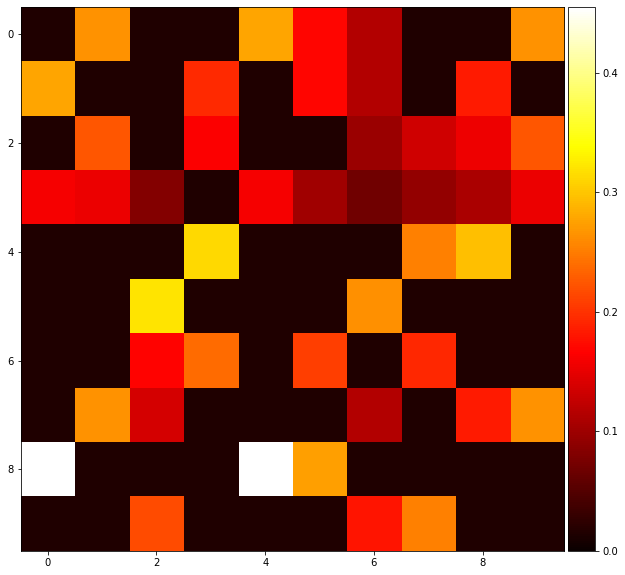

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(15,10))
ax = plt.subplot()
im = ax.imshow(google_matrix, cmap='hot', vmin=0)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

Vemos que en general los valores de la matriz resultan cercanos a $0$, y este efecto se magnifica para grafos más complejos.

## Implementación y resultados

Ahora si, implementamos el método para calcular el PageRank de nuestro grafo. Para ello vamos a utilizar el método de las potencias aplicado a la matriz $G$, sin embargo no vamos a calcular por completo esta matriz, ya que basta con usar la matriz subestocástica $H$ y utilizar la estrategía de las actualizaciones de rango $1$, que se puede consultar con detalle [aquí](https://leobouts.medium.com/rank-1-updates-in-linear-algebra-in-simple-terms-7b5032a11a3e). De esta forma no tenemos que guardar en memoria las matrices $G$ y $S$.

Notemos $\pi^{(k+1)T}$ como el vector de PageRank obtenido en la $k+1$-ésima iteración, luego la actualización de rango $1$ está dada por

$$\pi^{(k+1)T} = \alpha \pi^{(k)T}H+(\alpha \pi^{(k)T} a+1-\alpha)e^T/n$$

In [8]:
def dangling_correction(value):
    if value == 0:
        value = 1
    else:
        value = 0
    return value
find_dangling = np.vectorize(dangling_correction)

def pageRank(graph, tol=0.001, max_iter=50, alpha=0.85):
    N = len(graph)
    nodelist = list(graph)
    A = nx.adjacency_matrix(graph)
    S = A.sum(axis=1)
    S = np.divide(1, S, where=S!=0)
    Q = sp.sparse.spdiags(S.T, 0, *A.shape) 
    A = Q @ A #en este punto la matriz $A$ corresponde a la matriz subestocástica H
    x = np.repeat(1.0 / N, N)
    p = np.repeat(1.0 / N, N)
    dangling_weights = p
    is_dangling = np.where(S == 0)[0] #encontramos los nodos aislados o colgantes

    # método de potencias usando actualizaciones de rango 1 para la matriz
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x @ A) + (alpha * np.multiply(find_dangling(S).T, x)+1-alpha)/N #actualización de rango 1
        err = np.absolute(x - xlast).sum()
        if err < N * tol:
            break
    x = np.asarray(x)[0]
    page = dict(zip(nodelist, map(float, x)))    
    print('PageRank calculado con un error de {%.4f}'%err)
    return sorted(page.items(), key=lambda x:x[1], reverse=True)
pageRank(graph)

PageRank calculado con un error de {0.0047}


[(6, 0.15589144575334363),
 (2, 0.1448555509841178),
 (7, 0.11747140932773918),
 (5, 0.10864214545081018),
 (3, 0.09951343785037293),
 (8, 0.09540551574935699),
 (1, 0.07570668276504629),
 (9, 0.07570668276504629),
 (0, 0.06441470220061728),
 (4, 0.06239242715354938)]

Vemos que el nodo de mayor PageRank es el nodo $6$, seguido del nodo $2$, esto es debido a que a ellos llegan varias aristas o hipervínculos. Ahora comparemos nuestro resultado con el obtenido usando la librería networkx

In [9]:
rank = nx.pagerank(graph)
sorted(rank.items(), key=lambda x:x[1], reverse=True)

[(6, 0.15624574189918577),
 (2, 0.14507817823478422),
 (7, 0.11727518077775174),
 (5, 0.10843333482103884),
 (3, 0.09930579679982729),
 (8, 0.0954186613008336),
 (1, 0.07579904634869863),
 (9, 0.07579904634869863),
 (0, 0.06430002595669959),
 (4, 0.062344987512481645)]

Podemos ver que en este caso los resultados son muy similares, sin embargo hay casos en los que los resultados difieren, esto se debe a que la implementación del algoritmo en networkx utiliza algunas mejoras del algoritmo original. Algunas de las mejoras se pueden consultar en [A Survey of Eigenvector Methods for Web Information Retrieval](https://epubs.siam.org/doi/pdf/10.1137/S0036144503424786) o en [Google's PageRank and Beyond](https://gi.cebitec.uni-bielefeld.de/_media/teaching/2019winter/alggr/langville_meyer_2006.pdf).

Veamos un ejemplo en el que las dos implementaciones difieren

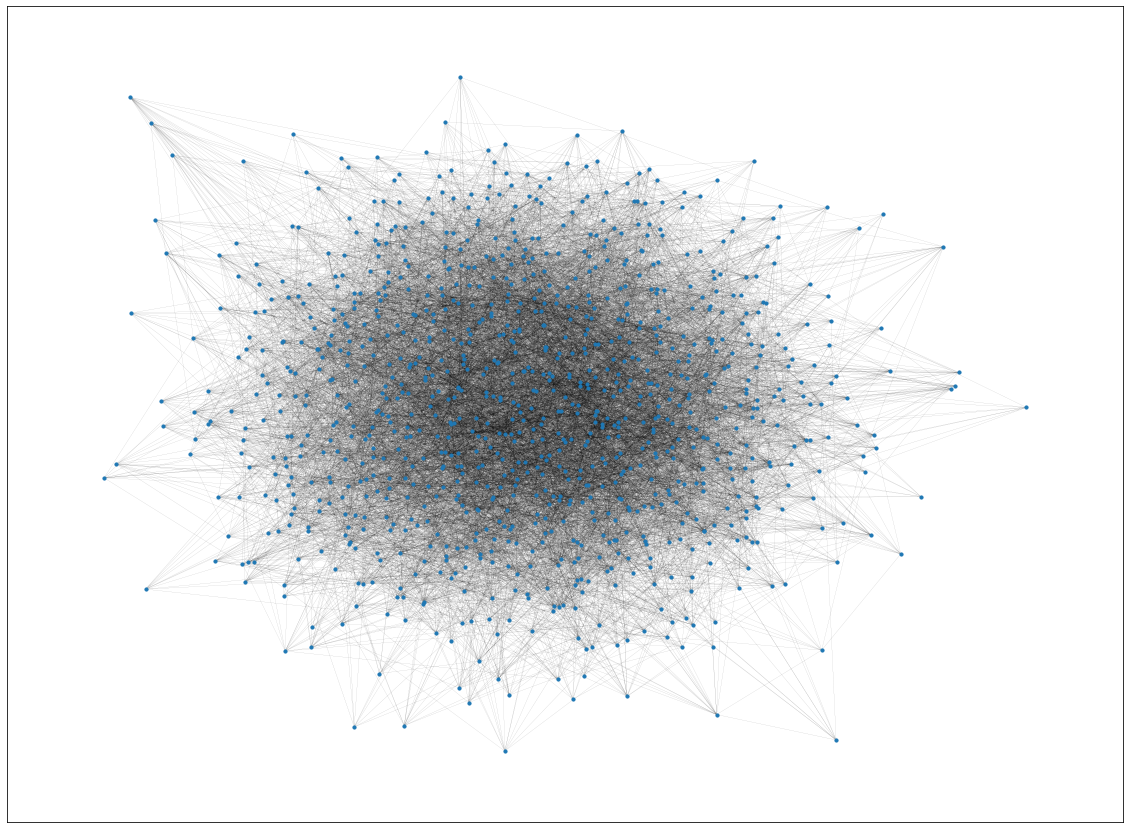

In [10]:
plt.figure(figsize=(20,15))
# created a directed graph
graph2 = nx.gnp_random_graph(1000, 0.01, directed=True, seed=1)
#draw a graph
nx.draw_networkx(graph2, with_labels=False, width=0.05, arrows=False, node_size=10)
#plot a graph
plt.show()

In [18]:
start = time.time()
print(pageRank(graph2)[:10])
print('-'*20)
print('Tiempo de ejecución:', time.time()-start)

PageRank calculado con un error de {0.2239}
[(773, 0.0020865875790875787), (956, 0.0020296013014763016), (92, 0.0018243320568320568), (246, 0.0018100717849402056), (139, 0.0018096405677655678), (378, 0.0017699345099345097), (517, 0.0017664812964812968), (966, 0.0017514256637082726), (982, 0.0017309387834387835), (42, 0.0017178697691197693)]
--------------------
Tiempo de ejecución: 0.11067628860473633


In [20]:
start = time.time()
rank = nx.pagerank(graph2)
print(sorted(rank.items(), key=lambda x:x[1], reverse=True)[:10])
print('-'*20)
print('Tiempo de ejecución:', time.time()-start)

[(773, 0.0020526522490993387), (966, 0.002036914726516935), (956, 0.001998867875927834), (517, 0.0019179983778161624), (92, 0.0018858141131486111), (732, 0.001832772039490436), (771, 0.001830454946191348), (982, 0.0017935081492158299), (972, 0.0017867085550921074), (631, 0.0017760546224429524)]
--------------------
Tiempo de ejecución: 0.049082040786743164
